In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers
import tensorflow as tf
train_data = pd.read_csv("gs://zw2624-bucket/input/large_train.csv")
test_data = pd.read_csv("gs://zw2624-bucket/input/large_test.csv")
train_data = train_data.rename(columns={"userId": "user_id", "movieId": "business_id"})
test_data = test_data.rename(columns={"userId": "user_id", "movieId": "business_id"})

Using TensorFlow backend.


## Process Data (encoding categorical data)

In [5]:
train_data['is_train'] = True
test_data['is_train'] = False
all_data = pd.concat([train_data,test_data])
all_data.user_id = all_data.user_id.astype('category').cat.codes.values
all_data.business_id = all_data.business_id.astype('category').cat.codes.values
is_train = all_data['is_train'] == True
train_data = all_data[is_train]
test_data = all_data[~is_train]

In [6]:
all_data

,user_id,business_id,date_review,rating_review,is_train
0,199184,137049,2013-05-07 04:34:36,1.0,True
1,199184,137049,2013-03-27 14:17:13,1.0,True
2,251909,137049,2012-08-17 21:58:24,3.0,True
3,244953,137049,2015-07-18 11:40:36,5.0,True
4,244953,137049,2015-04-06 14:45:57,4.0,True
...,...,...,...,...,...
844090,15012,72536,2018-10-05 23:43:16,1.0,False
844091,276265,43835,2018-10-21 17:13:53,2.0,False
844092,276265,27685,2018-10-27 20:27:46,5.0,False
844093,169413,137862,2015-05-07 23:03:49,5.0,False


## Build Model

In [7]:
n_latent_factors_user = 8
n_latent_factors_business = 10
n_latent_factors_mf = 3
n_users, n_business = len(all_data.user_id.unique()), len(all_data.business_id.unique())

In [8]:
business_input = keras.layers.Input(shape=[1],name='Item')
business_embedding_mlp = keras.layers.Embedding(n_business + 1, n_latent_factors_business, name='Business-Embedding-MLP')(business_input)
business_vec_mlp = keras.layers.Flatten(name='FlattenBusiness-MLP')(business_embedding_mlp)
business_vec_mlp = keras.layers.Dropout(0.2)(business_vec_mlp)

business_embedding_mf = keras.layers.Embedding(n_business + 1, n_latent_factors_mf, name='business-Embedding-MF')(business_input)
business_vec_mf = keras.layers.Flatten(name='Flattenbusiness-MF')(business_embedding_mf)
business_vec_mf = keras.layers.Dropout(0.2)(business_vec_mf)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

In [9]:
concat = keras.layers.concatenate([business_vec_mlp, user_vec_mlp], name='Concat')

concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(128, name='FullyConnected')(concat_dropout)
dense_act = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)(dense)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense_act)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(64,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)

dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3')(dense_3)
dense_4_act = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)(dense_4)

pred_mf = keras.layers.concatenate([business_vec_mf, user_vec_mf], name='Dot')
pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4_act)

combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp],name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100, name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100, name='FullyConnected-4')(result_combine)

result = keras.layers.Dense(1, name='Prediction')(deep_combine)

In [10]:
model = keras.Model([user_input, business_input], result)
model.compile(optimizer='adam',loss= 'mse', metrics =["accuracy", "mse"])

In [ ]:
history = model.fit([train_data.user_id.values, train_data.business_id.values], train_data.rating_review, epochs=8, validation_split=0.2, workers=2)

Train on 2894480 samples, validate on 723620 samples
Epoch 1/8
2894480/2894480 [==============================] - 3568s 1ms/step - loss: 1.2423 - accuracy: 0.3595 - mse: 1.2423 - val_loss: 2.2173 - val_accuracy: 0.1526 - val_mse: 2.2173
Epoch 5/8
2213568/2894480 [=====================>........] - ETA: 14:01 - loss: 1.2275 - accuracy: 0.3647 - mse: 1.2275

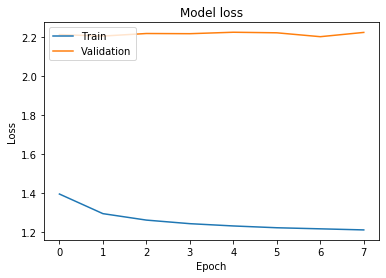

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation
### all reviews

In [15]:
from sklearn.metrics import mean_squared_error
prediction = model.predict([test_data.user_id.values, test_data.business_id.values])

In [16]:
y_hat_rounded = np.round(prediction, 0)
print(np.sqrt(mean_squared_error(test_data.rating_review, y_hat_rounded)))
print(np.sqrt(mean_squared_error(test_data.rating_review, prediction)))

1.4236361477479111
1.389772628584666


In [35]:
pd.DataFrame(prediction).to_csv('gs://zw2624-bucket/output/leaky_relu_prediction.csv')

In [18]:
test_data['predicted'] = pd.DataFrame(prediction)

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### User Coverage (Ranking)

In [24]:
test_data['predicted'] = pd.DataFrame(prediction)
correct = 0
for user in test_data.user_id.unique():
    real = np.argsort(test_data.loc[test_data['user_id'] == user]['rating_review'])
    pred = np.argsort(test_data.loc[test_data['user_id'] == user]['predicted'])
    correct += (list(real) == list(pred))
print(correct / len(test_data.user_id.unique()))

0.2147672951504274


### last review of each user

In [19]:
idx = test_data.groupby(['user_id'])['date_review'].transform(max) == test_data['date_review']
test_data_latest = test_data[idx]
print(np.sqrt(mean_squared_error(test_data_latest.rating_review, test_data_latest.predicted)))

1.4266472962050092


In [20]:
popular_user_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/popular_user_ID.csv")
popular_business_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/popular_business_ID.csv")
midpopular_user_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/midpopular_user_ID.csv")
midpopular_business_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/midpopular_business_ID.csv")
unpopular_user_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/unpopular_user_ID.csv")
unpopular_business_ID = pd.read_csv("gs://zw2624-bucket/input/yelp/unpopular_business_ID.csv")
train_data_2 = pd.read_csv("gs://zw2624-bucket/input/large_train.csv")
test_data_2 = pd.read_csv("gs://zw2624-bucket/input/large_test.csv")
train_data_2 = train_data_2.rename(columns={"userId": "user_id", "movieId": "business_id"})
test_data_2 = test_data_2.rename(columns={"userId": "user_id", "movieId": "business_id"})
train_data_2['is_train'] = True
test_data_2['is_train'] = False
all_data_2 = pd.concat([train_data_2,test_data_2])
all_data_2['user_id_code'] = all_data_2.user_id.astype('category').cat.codes.values
all_data_2['business_id_code'] = all_data_2.business_id.astype('category').cat.codes.values
is_train_2 = all_data_2['is_train'] == True
train_data_2 = all_data_2[is_train_2]
test_data_2 = all_data_2[~is_train_2]
test_data_pop = test_data_2.loc[test_data_2.user_id.isin(popular_user_ID.userId)]
test_data_mid = test_data_2.loc[test_data_2.user_id.isin(midpopular_user_ID.userId)]
test_data_unp = test_data_2.loc[test_data_2.user_id.isin(unpopular_user_ID.userId)]

### Rmse of different user segments

In [21]:
prediction_pop = model.predict([test_data_pop.user_id_code.values, 
                                                test_data_pop.business_id_code.values])
test_data_pop['predicted'] = pd.DataFrame(prediction_pop)
print(np.sqrt(mean_squared_error(test_data_pop.rating_review, prediction_pop)))

prediction_mid = model.predict([test_data_mid.user_id_code.values, 
                                                test_data_mid.business_id_code.values])
test_data_mid['predicted'] = pd.DataFrame(prediction_mid)
print(np.sqrt(mean_squared_error(test_data_mid.rating_review, prediction_mid)))

prediction_unp = model.predict([test_data_unp.user_id_code.values, 
                                                test_data_unp.business_id_code.values])
test_data_unp['predicted'] = pd.DataFrame(prediction_unp)
print(np.sqrt(mean_squared_error(test_data_unp.rating_review, prediction_unp)))

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1.2739861090189415


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.3669899588394583
1.4468697109682755


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Coverage of different user segments

In [ ]:
coverage_pop = 0
for user in test_data_pop.user_id_code.unique():
    real = np.argsort(test_data.loc[test_data['user_id'] == user]['rating_review'])
    pred = np.argsort(test_data.loc[test_data['user_id'] == user]['predicted'])
    coverage_pop += (list(real) == list(pred))
coverage_pop = coverage_pop / len(test_data_pop.user_id.unique())
print(coverage_pop)
coverage_mid = 0
for user in test_data_mid.user_id_code.unique():
    real = np.argsort(test_data.loc[test_data['user_id'] == user]['rating_review'])
    pred = np.argsort(test_data.loc[test_data['user_id'] == user]['predicted'])
    coverage_mid += (list(real) == list(pred))
coverage_mid = coverage_mid / len(test_data_mid.user_id.unique())
print(coverage_mid)
coverage_unp = 0
for user in test_data_unp.user_id_code.unique():
    real = np.argsort(test_data.loc[test_data['user_id'] == user]['rating_review'])
    pred = np.argsort(test_data.loc[test_data['user_id'] == user]['predicted'])
    coverage_unp += (list(real) == list(pred))
coverage_unp = coverage_unp / len(test_data_unp.user_id.unique())
print(coverage_unp)

0.21728991703137937
0.21048962571453922
0.2161435979035376


### Rmse of different business segments

In [25]:
test_data_pop_bus = test_data_2.loc[test_data_2.business_id.isin(popular_business_ID.businessId)]
test_data_mid_bus = test_data_2.loc[test_data_2.business_id.isin(midpopular_business_ID.businessId)]
test_data_unp_bus = test_data_2.loc[test_data_2.business_id.isin(unpopular_business_ID.businessId)]

prediction_pop_bus = model.predict([test_data_pop_bus.user_id_code.values, 
                                                test_data_pop_bus.business_id_code.values])
test_data_pop_bus['predicted'] = pd.DataFrame(prediction_pop_bus)
print(np.sqrt(mean_squared_error(test_data_pop_bus.rating_review, prediction_pop_bus)))

prediction_mid_bus = model.predict([test_data_mid_bus.user_id_code.values, 
                                                test_data_mid_bus.business_id_code.values])
test_data_mid_bus['predicted'] = pd.DataFrame(prediction_mid_bus)
print(np.sqrt(mean_squared_error(test_data_mid_bus.rating_review, prediction_mid_bus)))

prediction_unp_bus = model.predict([test_data_unp_bus.user_id_code.values, 
                                                test_data_unp_bus.business_id_code.values])
test_data_unp_bus['predicted'] = pd.DataFrame(prediction_unp_bus)
print(np.sqrt(mean_squared_error(test_data_unp_bus.rating_review, prediction_unp_bus)))

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1.2964927021321682


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1.564292639721157
1.6801095984191226


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
